This python code is used to generate plots regarding the evaluation of surface soil moisture agaist in-situ observations

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [3]:
def sm_memory(a):
    nt = len(a.time)
    time_day = pd.date_range(start='1900-01-01', periods=nt, freq='D')
    a  = a.assign_coords({"time": (time_day)})
    a0 = a.isel(time=slice(0,nt-2))
    time_bk = time_day[:nt-2]
    a1 = a.isel(time=slice(1,nt-1)).assign_coords({"time": (time_bk)})
    a2 = a.isel(time=slice(2,nt-0)).assign_coords({"time": (time_bk)})
    
    lac1 = np.log( xr.corr(a0,a1,dim='time') )
    lac2 = np.log( xr.corr(a0,a2,dim='time') )
    mem = -1. / ( lac2 - lac1 )
    err = 2. * lac1 - lac2
    return mem, err

In [4]:
dir = '/land1/ISMN/231201/'
site_list = sorted(glob.glob(dir+'*.csv'))

lons = []
lats = []
site = []
flag = [np.nan] * len(site_list)
site_list2 = []

for ff,f in enumerate(site_list):
    network = f.split("/")[4].split("_")[1]
    # print(network)
    # sys.exit()
    df = pd.read_csv(f,na_values=-9999)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # df2 = df.groupby(pd.Grouper(key='date_time', freq='D'))['soil_moisture'].mean()
    
    syr = df['date_time'].dt.year.min()
    eyr = df['date_time'].dt.year.max()
    
    if ( ( syr >= 1993 ) & ( syr <= 2016 ) ) | ( ( eyr >= 1993 ) & ( eyr <= 2016 ) ):
        if network != 'SNOTEL':
            lons.append(df['longitude'][0])
            lats.append(df['latitude'][0])
            site.append(df['station'][0])
            site_list2.append(f)
            flag[ff] = 1

In [5]:
obs = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/ISMN_ssm.nc4')['ssm']
sat = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/ESACCI_ssm.nc4')['ssm']
g5 = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/glosea5_ssm.nc4')['ssm']
g6 = xr.open_dataset('/home/eseo/python/GloSea/paper1/data/glosea6_ssm.nc4')['ssm']

In [6]:
ssm_obs = xr.DataArray(data = np.empty([len(g5.years),len(g5.init_dates),len(g5.leads),len(g5.site)]) * np.nan,
                       dims=["years","init_dates","leads","site"],
                       coords = dict(years=(["years"], g5.years.values),
                                     init_dates=(["init_dates"], g5.init_dates.values),
                                     leads=(["leads"], g5.leads.values),
                                     site=(["site"], g5.site.values),
                                    )
                      )

ssm_sat = ssm_obs.copy(deep=True)

syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        ntime = str(yr)+str(id)
        t1 = list(obs.time.values).index(obs.sel(time=ntime).time)
        ssm_obs[y,i,:,:] = obs[t1:t1+60,:]
        del t1
        if yr >= 2000:
            t1 = list(sat.time.values).index(sat.sel(time=ntime).time)
            ssm_sat[y,i,:,:] = sat[t1:t1+60,:]
            del t1
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [7]:
def cal_rmse(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a ) ** 2
    return ( diff.mean(dim) ) ** 0.5

def cal_bias(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a )
    return diff.mean(dim)

g5_rmse = cal_rmse(ssm_obs,g5/100.,('years','init_dates','leads')).mean('ensembles')
g6_rmse = cal_rmse(ssm_obs,g6/100.,('years','init_dates','leads')).mean('ensembles')
g5_bias = cal_bias(ssm_obs,g5/100.,('years','init_dates','leads')).mean('ensembles')
g6_bias = cal_bias(ssm_obs,g6/100.,('years','init_dates','leads')).mean('ensembles')

0.15319156663382008 -0.01920892405192263 0.41608116004250095 1.4272504259543138e-49


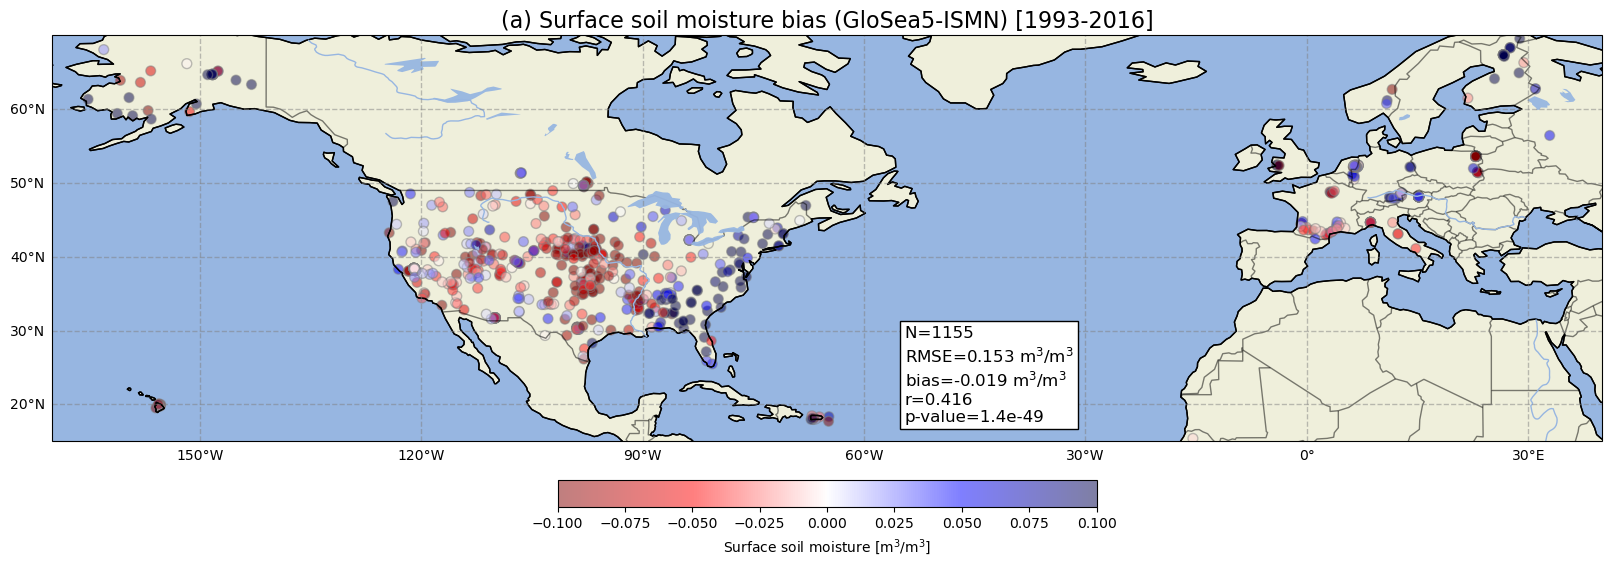

In [10]:
fname = './ismn_g5_ssm_bias_map.png'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))

plt.scatter(lons, lats, c=g5_bias, cmap='seismic_r', transform=ccrs.PlateCarree(),vmax=0.1,vmin=-0.1,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


x1 = g5.mean(dim=('years','init_dates','ensembles','leads')) / 100.
y1 = ssm_obs.mean(dim=('years','init_dates','leads'))
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]

rmse = g5_rmse.mean().values
bias = g5_bias.mean().values
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)


textstr1="\n".join(( 
    # f'N=%.0f ' %(len(flag)), 
    f'N=%.0f ' %(mask.sum()), 
    f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
    f'bias=%.3f m$^3$/m$^3$' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='Surface soil moisture [m$^3$/m$^3$]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('(a) Surface soil moisture bias (GloSea5-ISMN) [1993-2016]', fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

0.15149654209442376 -0.012981271074383849 0.43024219855836565 3.0524763535100797e-53


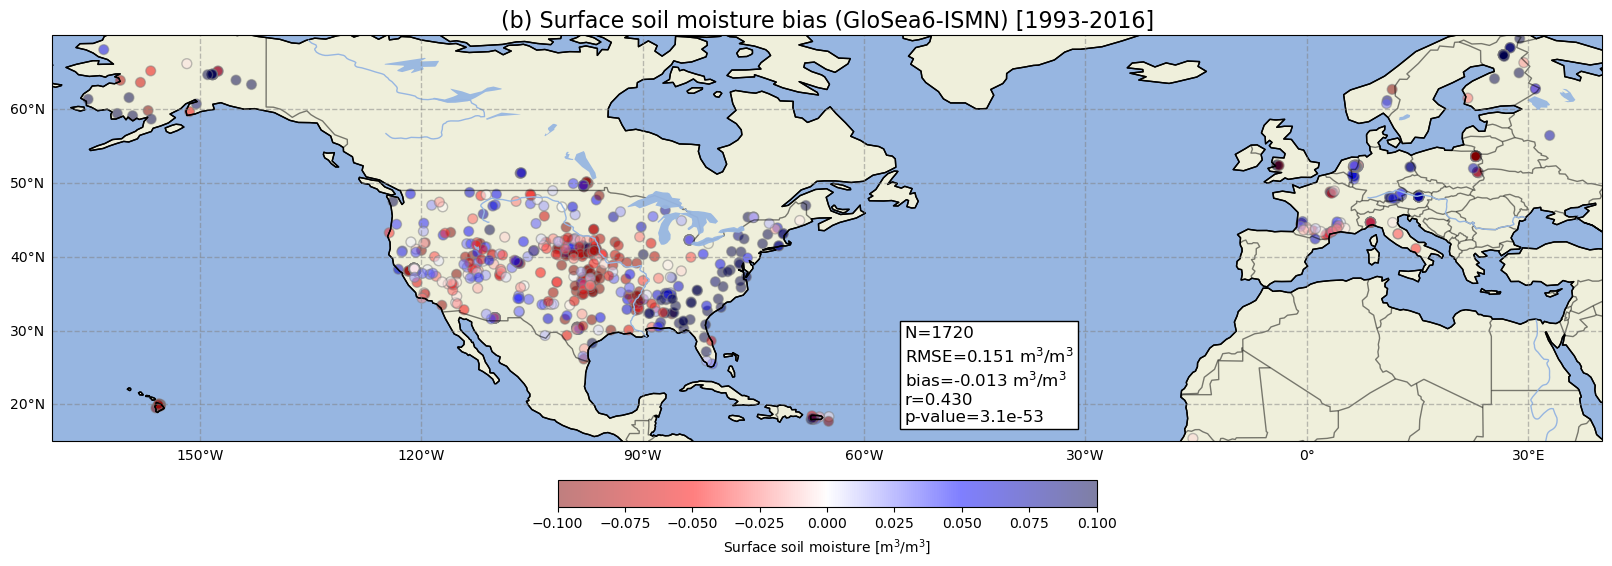

In [11]:
fname = './ismn_g6_ssm_bias_map.png'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))

plt.scatter(lons, lats, c=g6_bias, cmap='seismic_r', transform=ccrs.PlateCarree(),vmax=0.1,vmin=-0.1,s=50,alpha=0.5, edgecolor='gray')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-170, 40, 15, 70], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


x1 = g6.mean(dim=('years','init_dates','ensembles','leads')) / 100.
y1 = ssm_obs.mean(dim=('years','init_dates','leads'))
mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 
x = x1[mask]
y = y1[mask]

rmse = g6_rmse.mean().values
bias = g6_bias.mean().values
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)


textstr1="\n".join(( 
    f'N=%.0f ' %(len(flag)), 
    f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
    f'bias=%.3f m$^3$/m$^3$' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.55,0.05,textstr1,fontsize=12, bbox=props, transform=ax.transAxes)

plt.colorbar(label='Surface soil moisture [m$^3$/m$^3$]', orientation='horizontal', fraction=0.035, pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('(b) Surface soil moisture bias (GloSea6-ISMN) [1993-2016]', fontsize=16)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

0.15319156663382008 -0.01920892405192263 0.41608116004250095 1.4272504259543138e-49


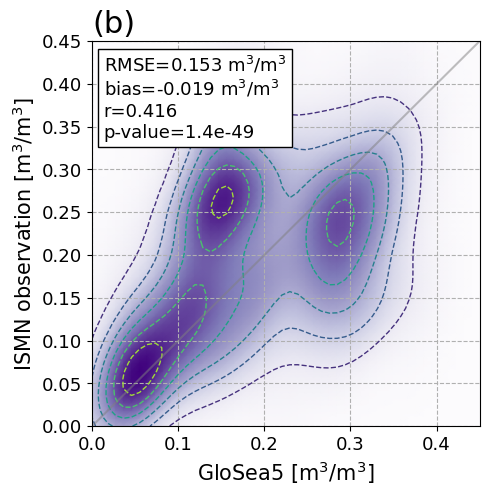

In [145]:
fname = './ismn_g5_sm_scatter.png'

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

x1 = g5.mean(dim=('years','init_dates','ensembles','leads')) / 100.
y1 = ssm_obs.mean(dim=('years','init_dates','leads'))

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = g5_rmse.mean().values
bias = g5_bias.mean().values
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 0.45; ymin = 0. ; ymax = 0.45

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('GloSea5 [m$^3$/m$^3$]', fontsize=15)
plt.ylabel('ISMN observation [m$^3$/m$^3$]', fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join(( 
    f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
    f'bias=%.3f m$^3$/m$^3$' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.03,0.75,textstr1,fontsize=13, bbox=props, transform=ax.transAxes)

plt.title('(b)', loc='left', fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

0.15149654209442376 -0.012981271074383849 0.43024219855836565 3.0524763535100797e-53


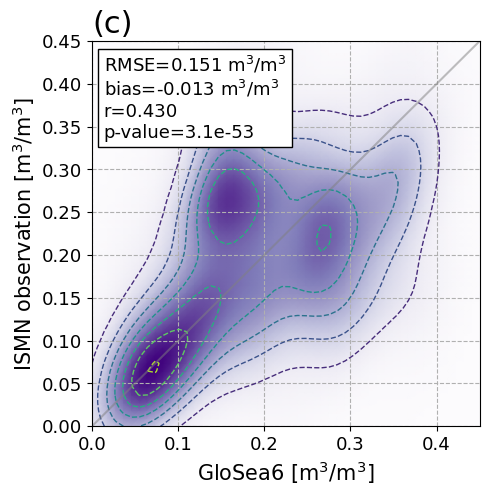

In [144]:
fname = './ismn_g6_sm_scatter.png'

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

from scipy import stats

x1 = g6.mean(dim=('years','init_dates','ensembles','leads')) / 100.
y1 = ssm_obs.mean(dim=('years','init_dates','leads'))

mask = ( ~np.isnan(x1) ) & ( ~np.isnan(y1) ) 

x = x1[mask]
y = y1[mask]

rmse = g6_rmse.mean().values
bias = g6_bias.mean().values
corr = stats.pearsonr(x,y)[0]
pval = stats.pearsonr(x,y)[1]
print(rmse,bias,corr,pval)

data = np.column_stack((x, y))
nbins = 50
xmin = 0. ; xmax = 0.45; ymin = 0. ; ymax = 0.45

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
plt.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
plt.xlabel('GloSea6 [m$^3$/m$^3$]', fontsize=15)
plt.ylabel('ISMN observation [m$^3$/m$^3$]', fontsize=15)
plt.grid(True, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=8)
add_identity(ax, color='gray', ls='-', alpha=0.5)

# textstr1="\n".join(( 
#     f'N=%.0f ' %(len(flag)), 
#     f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
#     f'bias=%.3f m$^3$/m$^3$' %(bias), 
#     f'r=%.3f' %(corr), 
#     f'p-value=%.1e' %(pval) 
# ))
textstr1="\n".join(( 
    f'RMSE=%.3f m$^3$/m$^3$' %(rmse), 
    f'bias=%.3f m$^3$/m$^3$' %(bias), 
    f'r=%.3f' %(corr), 
    f'p-value=%.1e' %(pval) 
))
props=dict(boxstyle="square",facecolor="white")
plt.text(0.03,0.75,textstr1,fontsize=13, bbox=props, transform=ax.transAxes)

plt.title('(c)', loc='left', fontsize=22)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()